In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset
blocksize = 3 # context length: how many characters do we take to predict the next one
splits = [0.8, 0.1, 0.1]

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * blocksize  # index of '.' characters
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
split1, split2 = int(splits[0]*len(words)), int((splits[0]+splits[1])*len(words))
X_train, Y_train = build_dataset(words[:split1])
X_val, Y_val = build_dataset(words[split1:split2])
X_test, Y_test = build_dataset(words[split2:])

X_train.shape, X_val.shape, X_test.shape
Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182625]), torch.Size([22655]), torch.Size([22866]))

In [35]:
# Define MLP
g = torch.Generator().manual_seed(2147483647)

def init_nn(hidden_dim=100, emb_dim=2):
    global C, W1, b1, W2, b2, parameters
    C = torch.randn((27, emb_dim), generator=g)
    W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g)
    b1 = torch.randn(hidden_dim, generator=g)
    W2 = torch.randn((hidden_dim, 27), generator=g) * 0.1
    b2 = torch.randn(27, generator=g) * 0
    
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    
# Long form
emb_dim = 10
hidden_dim = 200

# Lets create embedding (lookup table) for 27 characters into 2 dimensions
C = torch.randn((27, emb_dim), generator=g)

# Let us create hidden layer
# input layer has blocksize * 2 neurons (2 is embedding dimension)
W1 = torch.randn((blocksize * emb_dim, hidden_dim), generator=g) # * 0.2  # factor for problem 2 of dead neurons
b1 = torch.randn(hidden_dim, generator=g) # * 0.01  # factor for problem 2 of dead neurons

# Create output layer 
W2 = torch.randn((hidden_dim, 27), generator=g) * 0.1  # factor for problem 1 of initialization loss is off
b2 = torch.randn(27, generator=g) * 0  # factor for problem 1 of initialization loss is off

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [36]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 4.2326
  10000/ 200000: 2.1403
  20000/ 200000: 2.4720
  30000/ 200000: 2.5577
  40000/ 200000: 2.0154
  50000/ 200000: 2.4307
  60000/ 200000: 2.3385
  70000/ 200000: 2.0680
  80000/ 200000: 2.2665
  90000/ 200000: 2.1172
 100000/ 200000: 1.9299
 110000/ 200000: 2.0630
 120000/ 200000: 1.8901
 130000/ 200000: 2.3980
 140000/ 200000: 2.2826
 150000/ 200000: 2.1250
 160000/ 200000: 1.8469
 170000/ 200000: 1.7627
 180000/ 200000: 1.9119
 190000/ 200000: 1.8235


In [ ]:
# Let fix some problems with the MLP

# loss log history

# Original
# train loss: 2.20
# val loss: 2.25

# Fix 1: fix softmax confidendly wrong at init:
# train loss: 2.10
# val loss: 2.15
    

# Fix 2: fix tanh layer too saturated at init:
# train loss: 2.03
# val loss: 2.10

# Happening because more time in effective training (no additional training steps just for good initialization)

In [32]:
# 1. Initialization is off, would expect uniform distribution and on average the following loss for each character
# Shows we get initally ~20 vs. expect ~3.3
print(-torch.tensor(1/27).log())

# 4-dimensional examples of the issue
# logits = torch.tensor([-1.0, 20.0, 1.0, 1.0]) # problem, when logits have large differnce, can initlly guess very wrong
logits = torch.tensor([1.0, 1.0, 1.0, 1.0]) # all the same, fine (usually for symmetrie should all be 0)
#logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# E.g. first row of logits from inital MLP after first step of training with loss 27.88
# tensor([  9.8054, -10.7094, -18.9225,   4.5784,  25.0958,  12.3420,  25.2245,
#           2.3172,  23.1374, -15.8994,  -1.2803, -13.0714,  11.7869,  21.8830,
#         -10.2817, -10.7709,  13.7777,  -7.2771,  -1.5731,  15.3102,  -0.5203,
#         -18.8392,  30.8516,  16.5554, -18.1451,   2.9022, -36.2960],
#         grad_fn=<SelectBackward0>)

# Inital fix: b2 = 0, W2 scaled with 0.1
# b2=0, W2 * 0.1: inital loss from 27.8 to 4.2
# Why not set W2 to 0 -> can often cause problems (see later)
# b2=0, W2 * 0.01: inital loss to 3.3

# Two heuristics considering the loss
# - loss at initalization what you would expect, e.g. here uniform
# - loss should not be a hockey stick


tensor(3.2958)


(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [21]:
h.shape

torch.Size([32, 200])

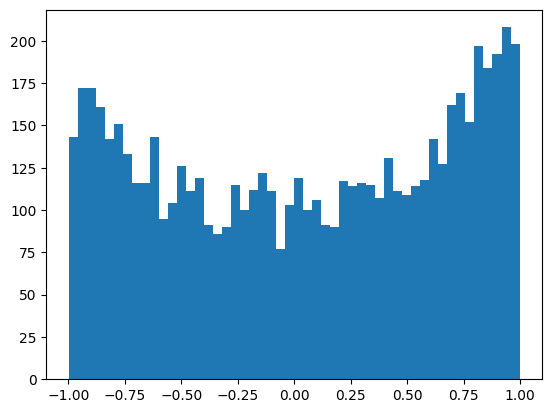

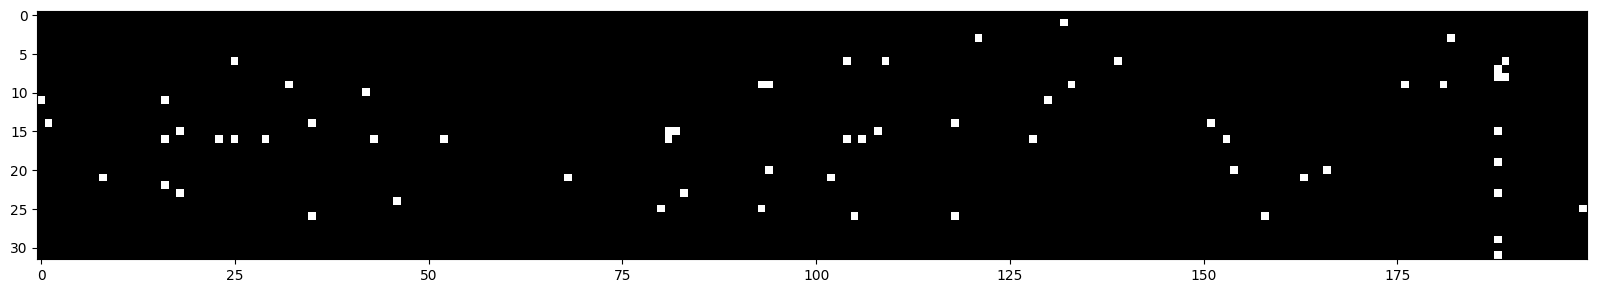

In [30]:
# 2. Most of hidden values are close to -1 and 1 -> should make us sweating aka "permanent brain damage of neurons"
# Again let model do only single update step
plt.hist(h.view(-1).tolist(), 50)

# Preactivations are very broad between -15 and 15 -> leading to squashing to -1 and 1 by the tanh
# plt.hist(hpreact.view(-1).tolist(), 50)

# Intuituvely for tanh, for -1 and 1 the gradient is very small -> so learning is slow
# Also consider backprop through tanh: (1 - t**2) * out.grad -> if t is close to -1 or 1, the gradient (1 - t**2) is close to 0
# => or to visualize the neuron is stuck in the flat region of tanh, even for relatively large changes in preactivation, we stick there
# => also, looking at (1 - t**2) * out.grad -> the gradient update through a tanh can only decreased (multiplied by sth. between 0 and 1)

# Lets check for occurrences in the hidden layer where large preactivation but small gradient
# => column of white = dead neuron
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # white is true --> lot of tanh are very active and in flat tail -> backward signal destroyed

# This problem also occurs for other activation functions, e.g. ReLU (https://medium.com/@shrutijadon/survey-on-activation-functions-for-deep-learning-9689331ba092)
# E.g. if ReLU neuron has negative preactivation, i.e. through all examples given the input weights and bias it is negative, then the neuron is dead
# => never activates, never gets gradient updates, stays dead forever
# => can happen during initialization, but also during training with too large learning rates

# Fixes:
# - change preactivations (i.e. incoming weights and/or bias) to be smaller -> less likely to be in flat region
# - b1 = b1*0.01 (Karpathy likes it to have some variation to help optimization)
# - W1 = W1*0.2

In [ ]:
logits[0]

tensor([  9.8054, -10.7094, -18.9225,   4.5784,  25.0958,  12.3420,  25.2245,
          2.3172,  23.1374, -15.8994,  -1.2803, -13.0714,  11.7869,  21.8830,
        -10.2817, -10.7709,  13.7777,  -7.2771,  -1.5731,  15.3102,  -0.5203,
        -18.8392,  30.8516,  16.5554, -18.1451,   2.9022, -36.2960],
       grad_fn=<SelectBackward0>)

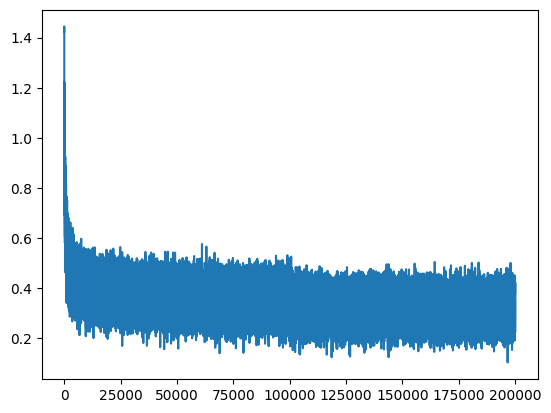

In [ ]:
plt.plot(lossi)

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test)
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.03735089302063
val 2.10432767868042


In [ ]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimri.
rehtlinna.
sane.
mahnen.
deliah.
jaree.
corrisephanaiir.
kaleigh.
ham.
join.
quinton.
lilea.
jamilio.
jerry.
jarynix.
kael.
drudi.
emmedo.
